In [1]:
import torch
from torch import tensor
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from collections import defaultdict

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

input_years = [2015, 2016, 2017]
target_years = [2021, 2022, 2023]

primary_tickers_file = "primary-tickers.csv"
input_file = "input.csv"

Using cuda device


In [2]:
types = defaultdict(lambda: np.float64, primary_ticker="string")

base_col = "totalAssets"

data_input = pd.read_csv(input_file).set_index("primary_ticker")
data_input = data_input[data_input[base_col]!=0]

from scipy import stats

returns = data_input["prediction"]/data_input["totalAssets"]
data_input = data_input[(returns <= 2) & (returns >= -10)]

# represent numbers in millions for better readability
for col in data_input.columns.values: data_input[col] /= 1e6
    
from sklearn.model_selection import train_test_split

trn_df,val_df = train_test_split(data_input, test_size=0.25)

In [3]:
def pmetrics(model, val_xs, val_df):
    predictions = model.predict(val_xs)

    rows = val_df[predictions.astype(bool)]
    returns = rows["prediction"]/rows["totalAssets"]
    portfolio_return = returns.mean()
    print(f"picked tickers={sorted(rows.index)}")
    print(f"portfolio return={portfolio_return*100:.2f}%")

    returns = sorted(val_df["prediction"]/val_df["totalAssets"], reverse=True)
    top_half_len = int(len(returns) * 0.50)
    top_half_returns = returns[:top_half_len]
    top_half_return_percentage = sum(top_half_returns)/len(top_half_returns) * 100
    print(f"top market return(50%)={top_half_return_percentage:.2f}%")
    
    rows = val_df.sample(int(len(returns)/2))
    returns = rows["prediction"]/rows["totalAssets"]
    portfolio_return = returns.mean()
    print(f"random portfolio return={portfolio_return*100:.2f}%")

def xs_y(df, dep):
    columns = np.delete(df.columns.values, -1)
    preds = df[dep]/df["totalAssets"] > 10/100
    preds = preds.astype(int)
    return df[columns], preds

trn_xs,trn_y = xs_y(trn_df, "prediction")
val_xs,val_y = xs_y(val_df, "prediction")

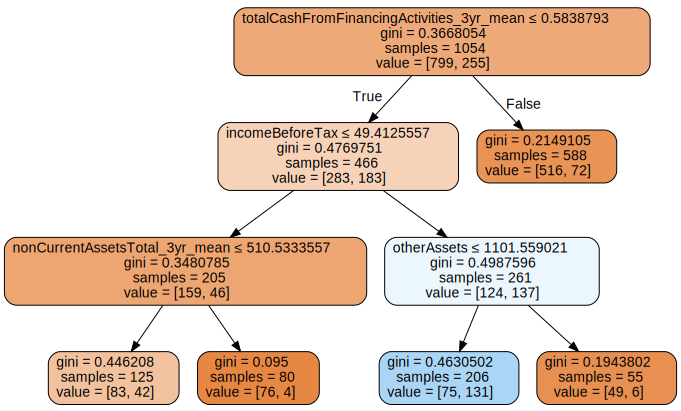

In [4]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error, accuracy_score

model = DecisionTreeClassifier(max_leaf_nodes=5).fit(trn_xs, trn_y);

import graphviz
import re

def draw_tree(tree, df, size=10, ratio=0.6, precision=7, **kwargs):
    s=export_graphviz(tree, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(model, trn_xs, size=50)

In [5]:
pmetrics(model, val_xs, val_df)

picked tickers=['AAL.US', 'ADM.US', 'AFL.US', 'AGX.US', 'AIR.US', 'ALSN.US', 'AME.US', 'AMED.US', 'AMGN.US', 'AMKR.US', 'AMSF.US', 'ANSS.US', 'APTV.US', 'ARCH.US', 'ARCO.US', 'ARR-PC.US', 'ARR.US', 'ASTE.US', 'BC.US', 'BEN.US', 'BFAM.US', 'BFS-PE.US', 'BFS.US', 'BIG.US', 'BIIB.US', 'BRKR.US', 'BRX.US', 'BTZ.US', 'BXP.US', 'CAKE.US', 'CARS.US', 'CBRE.US', 'CBRL.US', 'CBT.US', 'CHDN.US', 'CHE.US', 'CHH.US', 'CHK.US', 'CHX.US', 'CIGI.US', 'CLS.US', 'CMRE-PC.US', 'CMRE-PE.US', 'CNX.US', 'COLM.US', 'COO.US', 'CPRI.US', 'CRS.US', 'CSX.US', 'CVGW.US', 'CX.US', 'DAN.US', 'DBI.US', 'DE.US', 'DK.US', 'DLX.US', 'DRH-PA.US', 'EA.US', 'EHC.US', 'ENS.US', 'EPD.US', 'EVC.US', 'EW.US', 'EXLS.US', 'FDP.US', 'FHI.US', 'FICO.US', 'FLR.US', 'FOX.US', 'FR.US', 'FSV.US']
portfolio return=9.60%
top market return(50%)=11.81%
random portfolio return=-21.63%


In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
pmetrics(rf, val_xs, val_df)

picked tickers=['AAOI.US', 'ADTN.US', 'AGX.US', 'ALSN.US', 'AME.US', 'AMED.US', 'ANSS.US', 'ASTE.US', 'BC.US', 'BELFA.US', 'BEN.US', 'BIG.US', 'BRKR.US', 'CBRL.US', 'CHE.US', 'CHH.US', 'CHK.US', 'CMRE-PC.US', 'CMRE-PE.US', 'COLM.US', 'COO.US', 'CPRI.US', 'CTS.US', 'CVGW.US', 'DAN.US', 'DBI.US', 'DLX.US', 'EA.US', 'EHC.US', 'ENR.US', 'ENS.US', 'EPAM.US', 'EVC.US', 'EW.US', 'EXLS.US', 'EXP.US', 'FHI.US', 'FICO.US', 'FOX.US', 'FSV.US']
portfolio return=12.78%
top market return(50%)=11.81%
random portfolio return=-16.26%


portfolio return=15.54%
